In [1]:
import numpy as np
import idx2numpy, torch
import matplotlib.pyplot as plt
import random
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn

In [2]:
train_data = idx2numpy.convert_from_file('mnistdata/train-images.idx3-ubyte') / 255
train_label = idx2numpy.convert_from_file('mnistdata/train-labels.idx1-ubyte')
test_data = idx2numpy.convert_from_file('mnistdata/t10k-images.idx3-ubyte') / 255
test_label = idx2numpy.convert_from_file('mnistdata/t10k-labels.idx1-ubyte')

In [3]:
train_data = train_data.reshape(len(train_data),1, 28, 28)
test_data = test_data.reshape(len(test_data), 1, 28, 28)

In [4]:
train_data = torch.from_numpy(train_data).float()
test_data = torch.from_numpy(test_data).float()
train_label = torch.from_numpy(np.array(train_label))
test_label = torch.from_numpy(np.array(test_label))

In [5]:
train_label = train_label.to(torch.int64)
test_label = test_label.to(torch.int64)

In [6]:
batch_size = 64
train = TensorDataset(train_data, train_label)
test = TensorDataset(test_data, test_label)
train_loader = DataLoader(train, batch_size = batch_size)
test_loader = DataLoader(test, batch_size = batch_size)

In [7]:
class CNNModule(nn.Module):
    def __init__(self):
        super(CNNModule, self).__init__()
        self.forward_propogation = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16,kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Flatten(),
            nn.Linear(32*5*5, 16, bias=True),
            nn.ReLU(),
            
            nn.Linear(16, 10, bias=True),
            nn.ReLU()
        )
        
    def forward(self, x):
        output = self.forward_propogation(x)
        return output
    
model = CNNModule()
print(model)

CNNModule(
  (forward_propogation): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=800, out_features=16, bias=True)
    (8): ReLU()
    (9): Linear(in_features=16, out_features=10, bias=True)
    (10): ReLU()
  )
)


In [8]:
learning_rate = 0.1
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [9]:
def train(data_dataloader , model, loss_fn, optimizer):
    size = len(data_dataloader.dataset)
    lossess = []
    accuracies = []
    for batch, (x, y) in enumerate(data_dataloader):
        pred = model(x)
        loss = loss_fn(pred, y)
        cat =  torch.argmax(pred, dim=1)
        accuracy = (cat == y).float().mean()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch* len(x)
            print(f"Loss: {loss:>7f}   [{current:>5d}/{size:>5d}] Accuracy: {accuracy * 100:>7f}")
            print(f"Accuracy: {accuracy:>7f}")
            lossess.append(loss)
            accuracies.append(accuracy)
    return lossess, accuracies

In [10]:
def test(data_dataloader, model):
    size = len(data_dataloader.dataset)
    model.eval()
    test_loss, correct = 0,0
    with torch.no_grad():
        for (x, y) in data_dataloader:
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"\n Test Error: \n Avg loss: {test_loss:>8f} Test Accuracy:{correct * 100:>5f}% \n")
        

In [11]:
epochs = 2
losses , accuracies = [], []
for t in range(epochs):
    print(f"Epoch {t+1}\n----------------------------------------")
    loss, accuracy = train(train_loader, model, loss_fn, optimizer)
    for l, a in zip(loss, accuracy):
        losses.append(l)
        accuracies.append(a)
    test(test_loader, model)

Epoch 1
----------------------------------------
Loss: 2.293613   [    0/60000] Accuracy: 14.062500
Accuracy: 0.140625
Loss: 1.349900   [ 6400/60000] Accuracy: 64.062500
Accuracy: 0.640625
Loss: 0.624098   [12800/60000] Accuracy: 78.125000
Accuracy: 0.781250
Loss: 0.440221   [19200/60000] Accuracy: 84.375000
Accuracy: 0.843750
Loss: 0.295226   [25600/60000] Accuracy: 87.500000
Accuracy: 0.875000
Loss: 0.445273   [32000/60000] Accuracy: 84.375000
Accuracy: 0.843750
Loss: 0.230127   [38400/60000] Accuracy: 92.187500
Accuracy: 0.921875
Loss: 0.546876   [44800/60000] Accuracy: 76.562500
Accuracy: 0.765625
Loss: 0.399382   [51200/60000] Accuracy: 85.937500
Accuracy: 0.859375
Loss: 0.349056   [57600/60000] Accuracy: 90.625000
Accuracy: 0.906250

 Test Error: 
 Avg loss: 0.004878 Test Accuracy:88.190000% 

Epoch 2
----------------------------------------
Loss: 0.202926   [    0/60000] Accuracy: 92.187500
Accuracy: 0.921875
Loss: 0.379693   [ 6400/60000] Accuracy: 85.937500
Accuracy: 0.859375


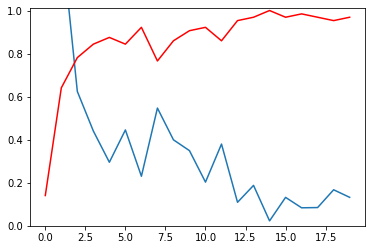

In [12]:
plt.plot(losses)
plt.plot(accuracies,color = "red")
plt.ylim(0,1.01)
plt.show()

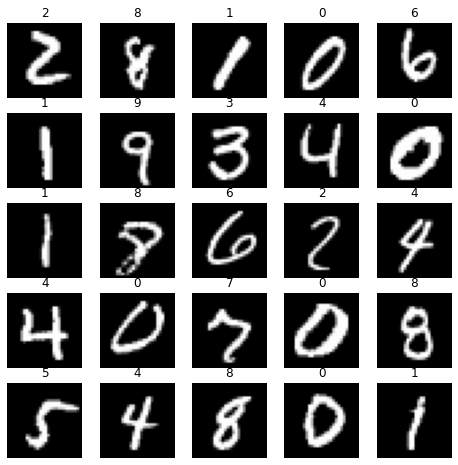

In [29]:
model.eval()
row , col = 5, 5
figure = plt.figure(figsize=(8,8))
for i in range(1, row*col+1):
    index = random.randint(1, len(test_data))
    x, y = test_data[index], test_label[index]
    x = torch.as_tensor(x.reshape(1,1, 28, 28), dtype=torch.float32)
    with torch.no_grad():
        pred = model(x)
        x = x.reshape(28, 28)
        predicted_num = pred[0].argmax(0).item()
        figure.add_subplot(row, col, i)
        plt.title(predicted_num)
        plt.axis('off')
        plt.imshow(x, cmap='gray')
        